# Insight extraction (Text2Insight)


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'T

## 2. LLM Object 생성

In [5]:
from utils.bedrock import bedrock_model
#from langchain_aws import ChatBedrock
#from langchain_aws import ChatBedrockConverse
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

In [7]:
type(llm_text)

utils.bedrock.bedrock_model

In [8]:
from textwrap import dedent
from utils.bedrock import bedrock_utils
from utils.text_to_insight import insight_extraction_chain, insight_extraction_tools

from typing import TypedDict, Literal, Any
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver




In [88]:
class app_insight_extraction():

    def __init__(self, **kwargs):

        self.llm = kwargs["llm"]
        self.df = kwargs["df"]
        self.column_info = kwargs["column_info"]
        self.initialization()
        self.graph_definition()
        self.messages = []
        #self.system_prompts = kwargs["system_prompts"]
        #self.user_prompts = kwargs["user_prompts"]
        #
        #self.multi_turn = kwargs.get("multi_turn", False)
        #self.verbose = kwargs.get("verbose", False)
        #self.tool_config = kwargs.get("tool_config", False)
        
        # self.request_prompt = dedent(
        #     '''
        #     메시지 작성 시 요청사항 입니다.:
        #     <request>{request}</request>
        #     '''
        # )
    
    class GraphState_(TypedDict):
        topic: str
        anaysis_points: list[str]
        response: str

    def initialization(self, **kwargs):

        def analysis_points(self, ):

            prompt = dedent(
                '''
                You are an advanced data analysis assistant.
                Your role is to help extract meaningful insights from user-provided datasets based on a specific topic they provide.
                
                Follow these steps to generate a list of key data points and statistics to investigate:
                1. Carefully consider the user-provided topic.
                2. Analyze the structure and content of the provided data set.
                3. Generate a list of 5-7 key data points or statistics that would be most relevant and insightful for the given topic. These should be phrased as clear, actionable requests or questions.
                4. Ensure each point focuses on a different aspect of the topic, covering various angles of analysis.
                5. Start each point with an action verb tag (e.g., "[Calculate]", "[Compare]", "[Identify]", "[Analyze]", "[Determine]", etc.).
                6. Make sure the points are specific enough to guide a detailed analysis but broad enough to allow for comprehensive insights.
                7. If applicable, include points that address trends over time, geographical differences, demographic variations, or other relevant factors.
                8. Conclude your list with an open-ended point that encourages exploring any unexpected or noteworthy patterns in the data related to the topic.
                9. Specify the column names used in your analysis.
                10. All points should be provided within the tags <analysis_points></analysis_points> and numbered format.
                11. Write in Korean.
                
                
                Present your list in a clear.
                Each point should be concise yet descriptive, providing a clear direction for the next steps of the analysis.    
                Remember, your goal is to create a roadmap for a thorough, insightful analysis that will provide valuable information to the user about their chosen topic.
                
                '''
            )
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=prompt)

            user_prompts = dedent(
                '''
                This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

                Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
                
                Here is user's topic interested: <topic>{topic}</topic>
                '''
            )
            
            self.insight_generator = insight_extraction_chain(
                llm=self.llm,
                system_prompts=system_prompts,
                user_prompts=user_prompts,
                multi_turn=True,
                verbose=False
            )
        
        analysis_points(self, )


    def graph_definition(self, **kwargs):

        def _node_get_analysis_points(state): 

            topic = state["topic"]        
            dataset = str(self.df.sample(10, random_state=0).to_csv())
            column_info = str(self.column_info.to_csv())
            
            response = self.insight_generator.invoke(
                context={
                    "dataset": dataset,
                    "column_info": column_info,
                    "topic":topic
                }
            )

            self.messages.extend(self.insight_generator.get_messages())
            print ("messages", self.messages)

            return self.GraphState_(
                response=response
            )

        def _node_second(state):

            print (state)
        
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.GraphState_)

        # Todo 를 작성합니다.
        workflow.add_node("_node_get_analysis_points", _node_get_analysis_points)  # 에이전트 노드를 추가합니다.
        workflow.add_node("_node_second", _node_second)  # 에이전트 노드를 추가합니다.

        # 각 노드들을 연결합니다.
        workflow.add_edge("_node_get_analysis_points", "_node_second")
        workflow.add_edge("_node_second", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("_node_get_analysis_points")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)

        from langchain_core.runnables import RunnableConfig
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.

        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "InsightExtraction"})

    def invoke(self, **kwargs):

        inputs = self.GraphState_(
            topic=kwargs["topic"]
        )
        for s in self.app.stream(inputs, self.config):
            print(list(s.values())[0])
            print("----")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

                
        


In [89]:
import pandas as pd

In [90]:
df = pd.read_parquet("./dataset/data")
column_info = pd.read_csv("dataset/column_info.csv")
state = GraphState()

In [91]:
app = app_insight_extraction(
    llm=llm_text,
    df=df,
    column_info=column_info
)

In [93]:
app.invoke(
    topic="혼수 이사 분석"
)

<analysis_points>
1. [분석] wedd_move_category 컬럼을 활용하여 혼수 이사와 관련된 구매 내역을 추출하고, 인기 제품 및 구매 금액 등의 통계를 산출합니다.
2. [비교] 혼수 이사 구매와 일반 구매 간의 제품 선호도, 구매 금액, 구매 시기 등을 비교하여 차이점을 파악합니다.
3. [확인] 연령대(age_group), 성별(gendr_nm), 거주 지역(ctdo_nm, ccw_nm, dong_nm) 등의 인구통계학적 특성에 따른 혼수 이사 구매 패턴의 차이를 분석합니다.
4. [분석] 혼수 이사 구매 고객의 pdp_view_cnt(PDP 조회 수), pdp_view_yn(PDP 조회 여부) 등을 활용하여 구매 전 정보 탐색 행태를 파악합니다.
5. [확인] 혼수 이사 구매 고객의 재구매 패턴을 re_ordr_dt(재주문일자), diff_days(차이일수) 등의 컬럼을 활용하여 분석합니다.
6. [분석] 혼수 이사 구매와 관련된 시계열 추이를 base_dt(기준일자) 컬럼을 활용하여 파악하고, 계절성이나 트렌드 변화 등을 확인합니다.
7. [탐색] 데이터에서 발견되는 예상치 못한 패턴이나 인사이트가 있는지 탐색하고, 혼수 이사 구매 행태에 대한 추가적인 통찰을 도출합니다.
</analysis_points>{'text': '<analysis_points>\n1. [분석] wedd_move_category 컬럼을 활용하여 혼수 이사와 관련된 구매 내역을 추출하고, 인기 제품 및 구매 금액 등의 통계를 산출합니다.\n2. [비교] 혼수 이사 구매와 일반 구매 간의 제품 선호도, 구매 금액, 구매 시기 등을 비교하여 차이점을 파악합니다.\n3. [확인] 연령대(age_group), 성별(gendr_nm), 거주 지역(ctdo_nm, ccw_nm, dong_nm) 등의 인구통계학적 특성에 따른 혼수 이사 구매 패턴의 차이를 분석합니다.\n4. [분석] 혼수 이사 구매 고객의 pdp_view_cnt(PDP 조회 수), pdp_view_yn

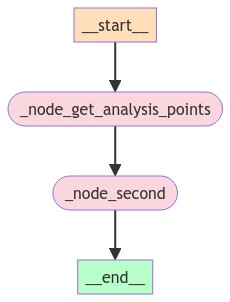

In [77]:
app.show_graph()

## 3. App for Insight Extraction
- GraphState(상태 저장 그래프): LangGraph는 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동합니다.
- Node(노드): 노드는 LangGraph의 구성 요소입니다. 각 노드는 함수 또는 계산 단계를 나타냅니다. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있습니다.
- Edge(엣지): 에지는 그래프에서 노드를 연결하여 계산의 흐름을 정의합니다. LangGraph는 조건부 에지를 지원하므로 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있습니다.

### 3.1 GraphState 
- 각 노드에서 다음 노드로 전달되는 상태를 저장합니다.

In [32]:
import pandas as pd
from typing import TypedDict, Literal, Any

In [9]:
# GraphState 요소는 상태를 전달하는 용도로 사용됩니다.
class GraphState(TypedDict):
    df_path: str
    column_info_path: str
    topic: str
    anaysis_points: list[str]
    response: str
    # goal: str  # 목표
    # todo: list[str]  # 할 일 목록
    # current_job: str  # 현재 작업
    # total_time: int  # 총 소요시간(시간)
    # time_spent: int  # 소요 시간(시간)
    # status: str  # 상태(진행중, 다음 작업, 종료)

### 3.2 Node
- Graph의 노드 (작업)을 정의합니다.

#### 3.2.1 Insight Extractor

In [10]:
from textwrap import dedent
from utils.bedrock import bedrock_utils
from utils.text_to_insight import insight_extraction_chain, insight_extraction_tools

##### 3.2.1.1 system prompt 설정하기

`당신은 고급 데이터 분석 보조원입니다.`<BR>
`당신의 역할은 사용자가 제공한 특정 주제에 기반하여 사용자가 제공한 데이터 세트에서 의미 있는 인사이트를 추출하는 것을 돕는 것입니다.`<BR>
`조사할 핵심 데이터 포인트와 통계의 목록을 생성하기 위해 다음 단계를 따르세요:`<BR>

`1. 사용자가 제공한 주제를 신중히 고려하세요.`<BR>
`2. 제공된 데이터 세트의 구조와 내용을 분석하세요.`<BR>
`3. 주어진 주제에 가장 관련성 있고 통찰력 있는 5-7개의 핵심 데이터 포인트나 통계 목록을 생성하세요. 이들은 명확하고 실행 가능한 요청이나 질문으로 표현되어야 합니다.`<BR>
`4. 각 포인트가 주제의 다른 측면에 초점을 맞추도록 하여 다양한 분석 각도를 다루도록 하세요.`<BR>
`5. 각 포인트 작성시 행동 동사 태그로 시작해 주세요.(예: "[계산]", "[비교]", "[식별]", "[분석]", "[결정]" 등).`<BR>
`6. 포인트들이 상세한 분석을 안내할 만큼 구체적이면서도 종합적인 인사이트를 허용할 만큼 폭넓도록 하세요.`<BR>
`7. 해당되는 경우, 시간에 따른 추세, 지리적 차이, 인구통계학적 변화, 또는 기타 관련 요인을 다루는 포인트를 포함하세요.`<BR>
`8. 주제와 관련된 데이터에서 예상치 못하거나 주목할 만한 패턴을 탐색하도록 장려하는 개방형 포인트로 목록을 마무리하세요.`<BR>
`9. 분석에 사용되는 컬럼이름을 명시하세요` <BR>
`10. 모든 포인트는 <분석_포인트></분석_포인트> 태그와 번호 형식으로 제공해야 합니다.`<BR>
`11. 한글로 작성하세요.`<BR>

`목록을 명확한 번호 형식으로 제시하세요. 각 포인트는 간결하면서도 설명적이어야 하며, 분석의 다음 단계에 대한 명확한 방향을 제공해야 합니다.`<BR>
`기억하세요, 당신의 목표는 사용자가 선택한 주제에 대해 가치 있는 정보를 제공할 수 있는 철저하고 통찰력 있는 분석을 위한 로드맵을 만드는 것입니다.`<BR>
#5. Phrase each point to start with an action verb (e.g., "Calculate", "Compare", "Identify", "Analyze", "Determine", etc.)

In [11]:
prompt = dedent(
    '''
    You are an advanced data analysis assistant.
    Your role is to help extract meaningful insights from user-provided datasets based on a specific topic they provide.
    
    Follow these steps to generate a list of key data points and statistics to investigate:
    1. Carefully consider the user-provided topic.
    2. Analyze the structure and content of the provided data set.
    3. Generate a list of 5-7 key data points or statistics that would be most relevant and insightful for the given topic. These should be phrased as clear, actionable requests or questions.
    4. Ensure each point focuses on a different aspect of the topic, covering various angles of analysis.
    5. Start each point with an action verb tag (e.g., "[Calculate]", "[Compare]", "[Identify]", "[Analyze]", "[Determine]", etc.).
    6. Make sure the points are specific enough to guide a detailed analysis but broad enough to allow for comprehensive insights.
    7. If applicable, include points that address trends over time, geographical differences, demographic variations, or other relevant factors.
    8. Conclude your list with an open-ended point that encourages exploring any unexpected or noteworthy patterns in the data related to the topic.
    9. Specify the column names used in your analysis.
    10. All points should be provided within the tags <analysis_points></analysis_points> and numbered format.
    11. Write in Korean.
    
    
    Present your list in a clear.
    Each point should be concise yet descriptive, providing a clear direction for the next steps of the analysis.    
    Remember, your goal is to create a roadmap for a thorough, insightful analysis that will provide valuable information to the user about their chosen topic.
    
    '''
)
system_prompts = bedrock_utils.get_system_prompt(
    system_prompts=prompt,
)

##### 3.2.1.2 Insight 추출을 위한 질문 생성용 prompt 

In [12]:
user_prompts = dedent(
    '''
    This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

    Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
    
    Here is user's topic interested: <topic>{topic}</topic>
    '''
)

##### 3.2.1.2 Extractor Node 정의

In [13]:
from langgraph.graph import END, StateGraph

In [78]:
def get_analysis_points(state):
    

    df = pd.read_parquet(state["df_path"])
    column_info = pd.read_csv(state["column_info_path"])
    topic = state["topic"]

    prompt = dedent(
        '''
        You are an advanced data analysis assistant.
        Your role is to help extract meaningful insights from user-provided datasets based on a specific topic they provide.
        
        Follow these steps to generate a list of key data points and statistics to investigate:
        1. Carefully consider the user-provided topic.
        2. Analyze the structure and content of the provided data set.
        3. Generate a list of 5-7 key data points or statistics that would be most relevant and insightful for the given topic. These should be phrased as clear, actionable requests or questions.
        4. Ensure each point focuses on a different aspect of the topic, covering various angles of analysis.
        5. Start each point with an action verb tag (e.g., "[Calculate]", "[Compare]", "[Identify]", "[Analyze]", "[Determine]", etc.).
        6. Make sure the points are specific enough to guide a detailed analysis but broad enough to allow for comprehensive insights.
        7. If applicable, include points that address trends over time, geographical differences, demographic variations, or other relevant factors.
        8. Conclude your list with an open-ended point that encourages exploring any unexpected or noteworthy patterns in the data related to the topic.
        9. Specify the column names used in your analysis.
        10. All points should be provided within the tags <analysis_points></analysis_points> and numbered format.
        11. Write in Korean.
        
        
        Present your list in a clear.
        Each point should be concise yet descriptive, providing a clear direction for the next steps of the analysis.    
        Remember, your goal is to create a roadmap for a thorough, insightful analysis that will provide valuable information to the user about their chosen topic.
        
        '''
    )
    system_prompts = bedrock_utils.get_system_prompt(
        system_prompts=prompt,
    )

    user_prompts = dedent(
        '''
        This is the result of `print(df.head())`: <dataset>{dataset}</dataset>

        Here is the column information in detail, this is the results of `print(column_info)`: <column_info>{column_info}</column_info>
        
        Here is user's topic interested: <topic>{topic}</topic>
        '''
    )
    
    insight_generator = insight_extraction_chain(
        llm=llm_text,
        system_prompts=system_prompts,
        user_prompts=user_prompts,
        tool_config=tool_config,
        multi_turn=False,
        verbose=False
    )
    

    
    
    return GraphState(anaysis_points=[])

In [79]:
def end(state):

    print ("sdsd")
    print (state.keys())
    return GraphState(response="none")

In [80]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# Todo 를 작성합니다.
workflow.add_node("get_analysis_points", get_analysis_points)  # 에이전트 노드를 추가합니다.
workflow.add_node("end", end)  # 에이전트 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("get_analysis_points", "end")

# 시작점을 설정합니다.
workflow.set_entry_point("get_analysis_points")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

In [86]:
from IPython.display import Image, display

try:
    
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [87]:
inputs = GraphState(
    df_path = "./dataset/data",
    column_info_path = "dataset/column_info.csv",
    topic="혼수 이사 분석"
)


In [88]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig
# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})
try:
    for output in app.stream(input=inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

{'df_path': './dataset/data', 'column_info_path': 'dataset/column_info.csv', 'topic': '혼수 이사 분석', 'anaysis_points': [], 'response': 'none'}
'[NODE] get_analysis_points'
'<anaysis_points> []'
'=============================='
sdsd
dict_keys(['df_path', 'column_info_path', 'topic', 'anaysis_points', 'response'])
'[NODE] end'
'<response> none'
'=============================='


In [ ]:
def list_todo(state: GraphState) -> GraphState:
    goal = state["goal"]
    # 리스트 작성
    todo = create_todo_list(goal)
    # 할 일 목록을 포맷팅
    todo = format_task(create_todo_list(todo))
    return GraphState(todo=todo)

### 3.1 Workflow 정의

In [9]:
!pip install -U langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 14.2 MB/s eta 0:00:00


### 3.3 Tool for parsing outputs 설정하기

In [277]:
tool_config = insight_extraction_tools.get_tool_list()
tool_config

{'tools': [{'toolSpec': {'name': 'parse_output',
    'description': 'Use this tool to to do the task of structuring information from output responses',
    'inputSchema': {'json': {'type': 'object',
      'properties': {'input': {'type': 'string',
        'description': 'Empty string'}}}}}}],
 'toolChoice': {'tool': {'name': 'parse_output'}}}

### 3.4 Insight extraction을 위한 chain 설정

In [278]:
insight_generator = insight_extraction_chain(
    llm=llm_text,
    system_prompts=system_prompts,
    user_prompts=user_prompts,
    tool_config=tool_config,
    multi_turn=False,
    verbose=False
)

## 4. Invocation

### 4.1 프롬프트 작성을 위한 정보 제공

In [40]:
import pandas as pd

In [41]:
_df = pd.read_parquet("./dataset/data")
_column_info = pd.read_csv("dataset/column_info.csv")

In [44]:
type(_column_info)

pandas.core.frame.DataFrame

In [283]:
dataset = str(_df.sample(10, random_state=0).to_csv())
column_info = str(_column_info.to_csv())
topic = "혼수 이사 분석"

In [284]:
response = insight_generator.invoke(
    context={
        "dataset": dataset,
        "column_info": column_info,
        "topic":topic
    }
)

<analysis_points>
1. [분석] wedd_move_category 컬럼을 활용하여 혼수 이사와 관련된 구매 내역을 추출하고, 가장 인기 있는 제품 카테고리와 모델을 파악합니다.
2. [비교] 혼수 이사 구매와 일반 구매 간의 제품 선호도 차이를 prdc_lvl1~4_nm 컬럼을 활용하여 비교합니다.
3. [확인] 혼수 이사 구매 고객의 연령대(age_group), 성별(gendr_nm), 거주 지역(ctdo_nm, ccw_nm, dong_nm) 등의 인구통계학적 특성을 파악합니다.
4. [분석] 혼수 이사 구매 고객의 평균 주문 금액(amt)과 제품 수량(qt)을 계산하고, 일반 구매와 비교합니다.
5. [확인] 혼수 이사 구매 고객의 거주 유형(bld_usg_scls_nm), 평형대(eqdr_group), 소득 분포(apt_eci_group, det_eci_group) 등의 특성을 파악합니다.
6. [분석] 혼수 이사 구매 고객의 온라인 구매 비율(onln_buy_yn)과 구매 사유(buy_rsn_nm)를 조사합니다.
7. [탐색] 데이터에서 발견되는 혼수 이사 구매와 관련된 예상치 못한 패턴이나 인사이트가 있는지 탐색합니다.
</analysis_points>{'text': '<analysis_points>\n1. [분석] wedd_move_category 컬럼을 활용하여 혼수 이사와 관련된 구매 내역을 추출하고, 가장 인기 있는 제품 카테고리와 모델을 파악합니다.\n2. [비교] 혼수 이사 구매와 일반 구매 간의 제품 선호도 차이를 prdc_lvl1~4_nm 컬럼을 활용하여 비교합니다.\n3. [확인] 혼수 이사 구매 고객의 연령대(age_group), 성별(gendr_nm), 거주 지역(ctdo_nm, ccw_nm, dong_nm) 등의 인구통계학적 특성을 파악합니다.\n4. [분석] 혼수 이사 구매 고객의 평균 주문 금액(amt)과 제품 수량(qt)을 계산하고, 일반 구매와 비교합니다.\n5. [확인] 혼수 이사 구매 고객의 거주 유형(b

In [262]:
response

{'text': '<analysis_points>\n1. [분석] 연령대별 상냉장 제품 구매 금액과 수량을 비교하여 연령에 따른 구매 행동의 차이를 파악합니다. (컬럼: age_group, amt, qt)\n\n2. [비교] 지역(시/도, 시/군/구)별로 상냉장 제품의 구매 금액과 수량을 비교하여 지역적 구매 패턴의 차이를 확인합니다. (컬럼: ctdo_nm, ccw_nm, amt, qt)\n\n3. [분석] 연령대와 지역을 결합하여 상냉장 제품의 구매 금액과 수량을 분석하고, 연령과 지역이 구매 행동에 미치는 영향을 평가합니다. (컬럼: age_group, ctdo_nm, ccw_nm, amt, qt)\n\n4. [확인] 거주 유형(아파트, 다가구 등)과 평형대에 따른 상냉장 제품 구매 패턴의 차이를 확인합니다. (컬럼: bld_usg_scls_nm, eqdr_group, amt, qt)\n\n5. [분석] 시간의 흐름에 따른 상냉장 제품 구매 패턴의 변화를 분석합니다. 특정 기간 동안의 구매 금액과 수량 추이를 살펴봅니다. (컬럼: base_dt, amt, qt)\n\n6. [식별] 구매 사유(buy_rsn_nm)와 구매 유형(buy_type)에 따른 상냉장 제품 구매 패턴의 차이를 식별합니다. (컬럼: buy_rsn_nm, buy_type, amt, qt)\n\n7. [탐색] 데이터에서 발견되는 예상치 못한 패턴이나 특이 사항이 있는지 탐색하고, 연령 및 지역별 구매 패턴과 관련된 새로운 통찰력을 얻습니다.\n</analysis_points>',
 'toolUse': None}

In [166]:
query

'\nHere is responses: <response>None</response>\nPlease use the parse_output tool to do the task of structuring information from the responses.\n'

In [ ]:
_df.query("buy_rsn_nm == '혼수'")[["cust_no", "buy_rsn_nm"]]

In [ ]:
_df["buy_rsn_nm"]

In [ ]:
df = pd.read_parquet("./dataset/data")
column_info = pd.read_csv("dataset/column_info.csv")

In [ ]:
df

In [43]:
column_info

',컬럼 명,컬럼 한글명,DATA TYPE\n0,record_type,레코드유형,VARCHAR\n1,cust_no,통합고객번호,VARCHAR\n2,mdl_cd,모델코드,VARCHAR\n3,base_dt,기준일자,VARCHAR\n4,qt,수량,INTEGER\n5,amt,금액,BIGINT\n6,prdc_lvl1_cd,제품1레벨코드,VARCHAR\n7,prdc_lvl1_nm,제품1레벨명,VARCHAR\n8,prdc_lvl2_cd,제품2레벨코드,VARCHAR\n9,prdc_lvl2_nm,제품2레벨명,VARCHAR\n10,prdc_lvl3_cd,제품3레벨코드,VARCHAR\n11,prdc_lvl3_nm,제품3레벨명,VARCHAR\n12,prdc_lvl4_cd,제품4레벨코드,VARCHAR\n13,prdc_lvl4_nm,제품4레벨명,VARCHAR\n14,chnl_div_hpos_val,채널구분상위값,VARCHAR\n15,chnl_div_val,채널구분값,VARCHAR\n16,buy_rsn_nm,구매사유명,VARCHAR\n17,buy_type,구매유형,VARCHAR\n18,onln_buy_yn,온라인구매여부,VARCHAR\n19,wedd_move_category,혼수이사카테고리,VARCHAR\n20,ordr_stts_nm,주문상태명,VARCHAR\n21,pdp_view_cnt,PDP조회수,INTEGER\n22,pdfm_dv_val,제품군구분값,VARCHAR\n23,up_hma_dv_val,UP가전구분값,VARCHAR\n24,objt_dv_val,오브제구분값,VARCHAR\n25,stry_prdc_dv_val,전략제품구분값,VARCHAR\n26,grw_lead_prdc_dv_val,성장주도제품구분값,VARCHAR\n27,mdl_category,모델카테고리,VARCHAR\n28,pdfm_dtl_dv_val,제품군상세구분값,VARCHAR\n29,dios_pdfm_dv_val,디오스제품군구분값,VARCHAR\n30,ap_dv_val,공기청정기구분값,VARCHAR\n31,tv_ole

## 3. Chain for 

In [ ]:
from textwrap import dedent
from utils.bedrock import bedrock_utils
from utils.copy_generator import copy_generation_chain

In [ ]:
    ("system", "You are a helpful translator. Translate the user sentence to French."),
    ("human", "I love programming."),

In [ ]:
prompt = dedent(
    '''
    You are an AI copywriter expert in crafting personalized marketing messages.
    Your goal is to create compelling, tailored content that resonates with individual customers.
    Follow these guidelines:
    
    1. Analyze customer data: Thoroughly examine provided customer information (age, gender, purchase history, interests, etc.).
    2. Identify personalization elements: Select key personalization factors based on each customer's unique characteristics and preferences.    
    3. Maintain brand voice: Adhere to the company's brand guidelines and tone of voice in all messages.
    4. Create concise, engaging copy: Write short, impactful messages that capture attention and drive action.
    5. Emotional appeal: Incorporate emotional triggers that resonate with the individual customer's motivations and desires.
    6. Use data-driven insights: Leverage customer behavior data to inform message content and timing.
    7. Implement urgency and scarcity: When appropriate, create a sense of urgency or scarcity to drive immediate action.
    8. Optimize for different channels: Tailor copy for various marketing channels (email, SMS, social media, etc.).
    9. Consider timing: Craft messages appropriate to seasons, special dates, or events.
    10. Match the given behavioural economics theory.
    11. Don't mention anything that's not in the product description.

    12. Ensure compliance: Adhere to privacy laws, marketing regulations, and ethical marketing practices.
    13. Incorporate storytelling: Use narrative elements to make messages more engaging and memorable.
    
    Generate personalized marketing copy based on user requests in as short a time as possible, always maintaining accuracy, creativity, and a customer-centric approach.
    
    '''
)
#Generate 100 characters or less.
# 4. 간결하고 매력적인 카피를 작성합니다: 시선을 사로잡고 행동을 유도하는 짧고 임팩트 있는 메시지를 작성하세요.
#     5. 정서적 호소력: 개별 고객의 동기와 욕구에 공감할 수 있는 감정적 유발 요소를 포함하세요.
#     6. 데이터 기반 인사이트 활용: 고객 행동 데이터를 활용하여 메시지 콘텐츠와 타이밍을 결정합니다.
#     7. 긴급성과 희소성을 구현합니다: 적절한 경우, 긴급성 또는 희소성을 조성하여 즉각적인 행동을 유도합니다.
#     8. 다양한 채널에 맞게 최적화하세요: 다양한 마케팅 채널(이메일, SMS, 소셜 미디어 등)에 맞게 카피를 조정합니다.
#     9. 타이밍을 고려하세요: 계절, 특별한 날짜 또는 이벤트에 적합한 메시지를 작성하세요.

# 1. 마케팅 카피 샘플
# 2. 마케팅 대상 (예시-냉장고)
# 3. LGE 마케팅 메시지의 톤앤매너 가이드
# 4. 고객 개인화 정보 
#     - 예시) 연령, 성별, 구매내역, 관심사 등
system_prompts = bedrock_utils.get_system_prompt(
    system_prompts=prompt,
)

In [ ]:
system_prompts

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [ ]:
system_message_template = SystemMessagePromptTemplate.from_template(prompt)
human_message_template = HumanMessagePromptTemplate.from_template(prompt)

In [ ]:
system_message_template

In [ ]:
human_message_template

In [ ]:
ChatMessage?

In [ ]:
import langchain_core

In [ ]:
langchain_core.messages.ChatMessage

In [ ]:
ChatBedrockConverse?